 O conjunto de dados, é sobre os preços históricos de ações (últimos 5 anos) para todas as empresas atualmente encontradas no índice S&P 500. Neste projeto será feito, uma análise exploratória, e serão criados 3 modelos preditivos, com o objetivo de prever o valor da ação. Serão utilizados os algoritmos de regressão linear, de redes neurais LSTM (Long Short-Term Memory) e o ARIMA (Auto Regressive Integrated Moving Averages).

Link dataset: https://www.kaggle.com/datasets/camnugent/sandp500

In [1]:
import pandas as pd

# Carregar os dados
df = pd.read_csv("/content/drive/MyDrive/Dataset S&P/all_stocks_5yr.csv")

# Visualizar as primeiras linhas da tabela
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


O dataset contém as seguintes colunas:

date: Data das observações (tipo object, deve ser convertido para datetime para análises temporais).

open: Preço de abertura da ação (tipo float).

high: Preço mais alto alcançado no dia (tipo float).

low: Preço mais baixo alcançado no dia (tipo float).

close: Preço de fechamento da ação (tipo float).

volume: Volume de ações negociadas (tipo int).

Name: Nome do ativo (tipo object).

In [2]:
# Verificando valores ausentes
df.isnull().sum()

date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64

In [3]:
# Removendo linhas com valores ausentes
df = df.dropna()

# Verificando novamente se ainda há valores ausentes
df.isnull().sum()

date      0
open      0
high      0
low       0
close     0
volume    0
Name      0
dtype: int64

In [ ]:
# Obtendo estatísticas descritivas
df.describe()

,open,high,low,close,volume
count,619029.000000,619029.000000,619029.000000,619029.000000,6.190290e+05
mean,83.023334,83.778419,82.256200,83.043305,4.321892e+06
std,97.378769,98.207735,96.507634,97.388913,8.693671e+06
min,1.620000,1.690000,1.500000,1.590000,1.010000e+02
25%,40.220000,40.620000,39.830000,40.240800,1.070351e+06
50%,62.590000,63.150000,62.020000,62.620000,2.082165e+06
75%,94.370000,95.180000,93.540000,94.410000,4.284550e+06
max,2044.000000,2067.990000,2035.110000,2049.000000,6.182376e+08


A análise estatística dos dados limpos revela:

Preço de Abertura (open): Média de 83.02, com um mínimo de 1.62, e um máximo de 2044.00.

Preço Máximo (high): Média de 83.78, variando de 1.69 a 2067.99.

Preço Mínimo (low): Média de 82.26, com valores entre 1.50 e 2035.11.

Preço de Fechamento (close): Média similar ao preço de abertura, 83.04, com valores entre 1.59 e 2049.00.

Volume: Média de cerca de 4.32 milhões de ações negociadas por dia, mas com uma grande variação (desvio padrão de aproximadamente 8.69 milhões) e um valor máximo de mais de 618 milhões de ações.

In [ ]:
# Calculando a matriz de correlação
df[['open', 'high', 'low', 'close', 'volume']].corr()

,open,high,low,close,volume
open,1.000000,0.999939,0.999928,0.999872,-0.142705
high,0.999939,1.000000,0.999903,0.999936,-0.142316
low,0.999928,0.999903,1.000000,0.999939,-0.143240
close,0.999872,0.999936,0.999939,1.000000,-0.142802
volume,-0.142705,-0.142316,-0.143240,-0.142802,1.000000


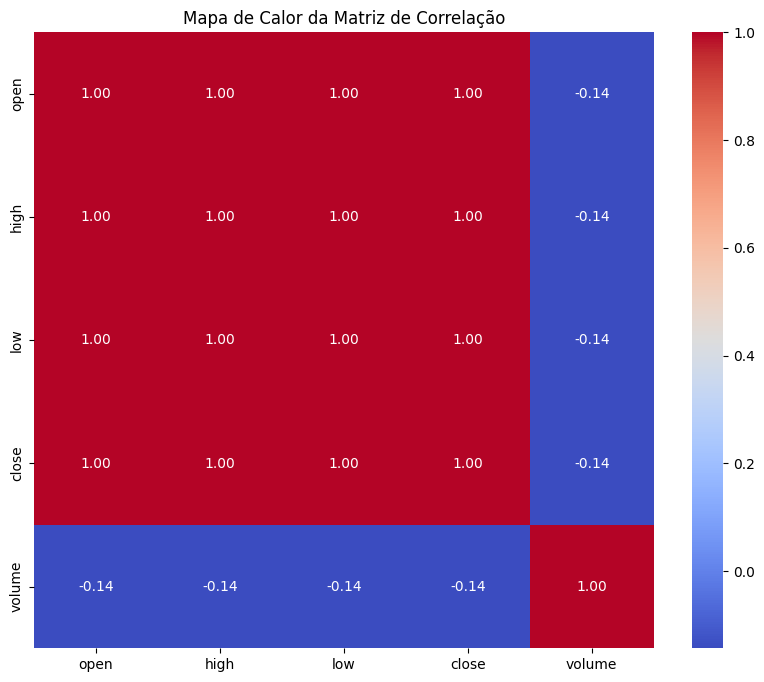

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criando um mapa de calor para visualizar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(df[['open', 'high', 'low', 'close', 'volume']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Mapa de Calor da Matriz de Correlação")
plt.show()

A matriz de correlação e o mapa de calor revelam o seguinte:

Correlações Altas entre Open, High, Low, e Close: Como esperado, os preços de abertura (open), máximo (high), mínimo (low) e fechamento (close) estão fortemente correlacionados entre si (correlações superiores a 0.99). Isso indica que, em geral, quando um destes preços é alto (ou baixo), os outros também tendem a ser altos (ou baixos) no mesmo dia.

Correlação Negativa com Volume: Existe uma leve correlação negativa entre o volume de ações negociadas e os preços das ações. Esta correlação, embora fraca, sugere que em dias com volume de negociação mais alto, os preços das ações tendem a ser ligeiramente menores, e vice-versa.

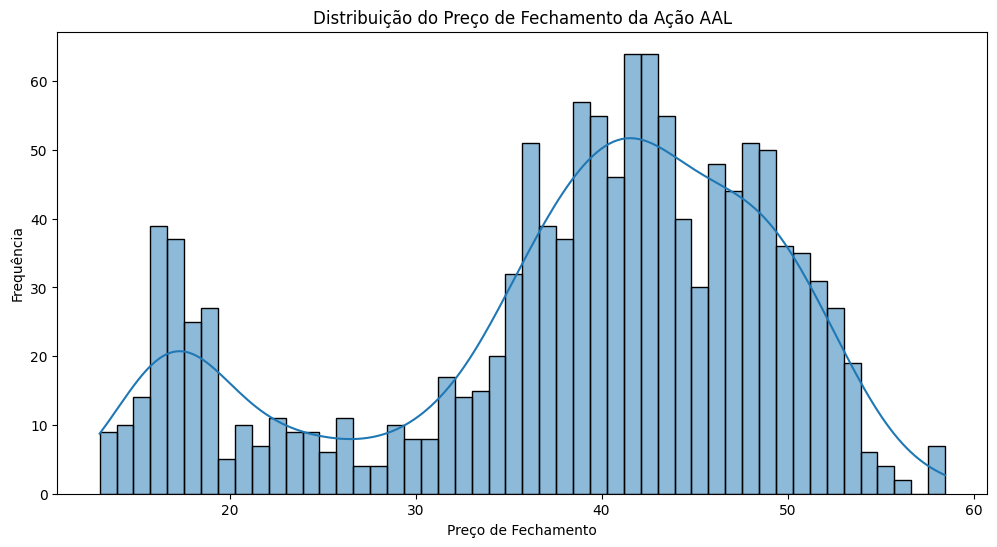

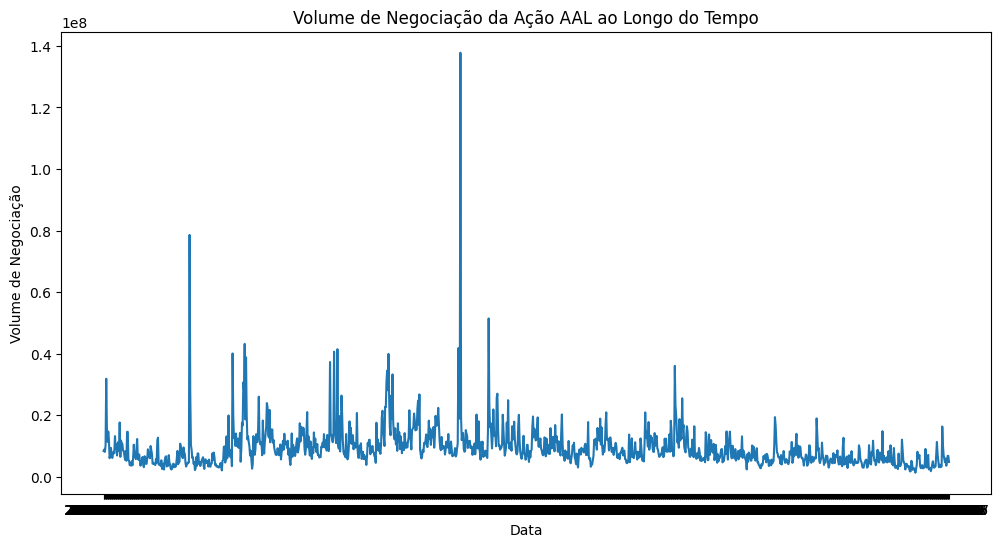

In [ ]:
# Filtrando os dados para a ação "AAL" (American Airlines)
aal_data = df[df['Name'] == 'AAL']

# Plotando o histograma dos preços de fechamento
plt.figure(figsize=(12, 6))
sns.histplot(aal_data['close'], bins=50, kde=True)
plt.title("Distribuição do Preço de Fechamento da Ação AAL")
plt.xlabel("Preço de Fechamento")
plt.ylabel("Frequência")
plt.show()

# Plotando o gráfico de linha para o volume de negociação ao longo do tempo
plt.figure(figsize=(12, 6))
sns.lineplot(x=aal_data['date'], y=aal_data['volume'])
plt.title("Volume de Negociação da Ação AAL ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("Volume de Negociação")
plt.show()

Distribuição do Preço de Fechamento: A distribuição dos preços de fechamento mostra uma tendência central em torno de um valor específico, com caudas que indicam variações ocasionais para preços mais altos ou mais baixos. A distribuição não é perfeitamente simétrica, sugerindo que os preços podem variar significativamente ao longo do tempo, mas tendem a se concentrar em torno de um valor médio.

Volume de Negociação ao Longo do Tempo: O gráfico de volume de negociação ao longo do tempo mostra flutuações significativas. Existem picos específicos onde o volume de negociação aumentou drasticamente, o que pode estar relacionado a eventos de mercado ou notícias corporativas específicas.

Iremos criar o modelo preditivo utilizando o algoritmo de regressão linear.

Mean Absolute Error (MAE): 0.3383278455668263
Mean Squared Error (MSE): 0.4710346681497113
R^2 Score: 0.9999514048327728


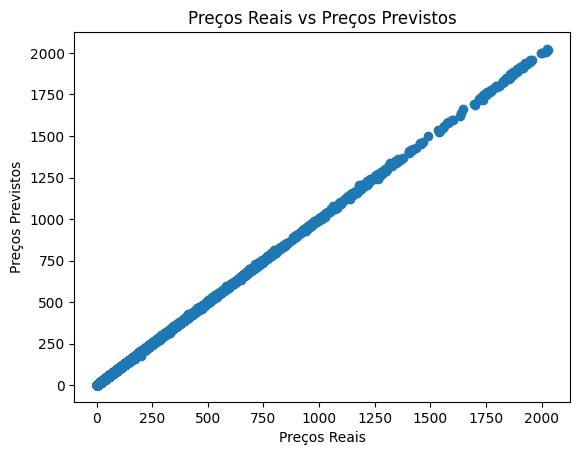

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Carregar os dados
df

# Aqui estou supondo que você quer prever o preço de fechamento com base em outras features
# como preço de abertura, volume, etc. Você pode ajustar as colunas conforme necessário.
X = df[['open', 'high', 'low', 'volume']]  # Exemplo de variáveis independentes
y = df['close']  # Variável dependente

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Criar o modelo de regressão linear
model = LinearRegression()
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Avaliação do modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

# Visualizar os resultados
plt.scatter(y_test, y_pred)
plt.xlabel('Preços Reais')
plt.ylabel('Preços Previstos')
plt.title('Preços Reais vs Preços Previstos')
plt.show()

Iremos criar o modelo preditivo utilizando o algoritmo de reredes neurais LSTM (Long Short-Term Memory).

Epoch 1/10
7737/7737 [==============================] - 986s 127ms/step - loss: 2.3788e-05
Epoch 2/10
7737/7737 [==============================] - 964s 125ms/step - loss: 1.1061e-05
Epoch 3/10
7737/7737 [==============================] - 964s 125ms/step - loss: 9.8984e-06
Epoch 4/10
7737/7737 [==============================] - 965s 125ms/step - loss: 9.8511e-06
Epoch 5/10
7737/7737 [==============================] - 968s 125ms/step - loss: 9.4428e-06
Epoch 6/10
7737/7737 [==============================] - 964s 125ms/step - loss: 8.8871e-06
Epoch 7/10
7737/7737 [==============================] - 965s 125ms/step - loss: 8.9422e-06
Epoch 8/10
7737/7737 [==============================] - 963s 124ms/step - loss: 8.2513e-06
Epoch 9/10
7737/7737 [==============================] - 962s 124ms/step - loss: 8.8834e-06
Epoch 10/10
3869/3869 [==============================] - 109s 28ms/step
MAE: 0.9929993604665365
MSE: 11.963739555934035
R²: 0.998766328721553


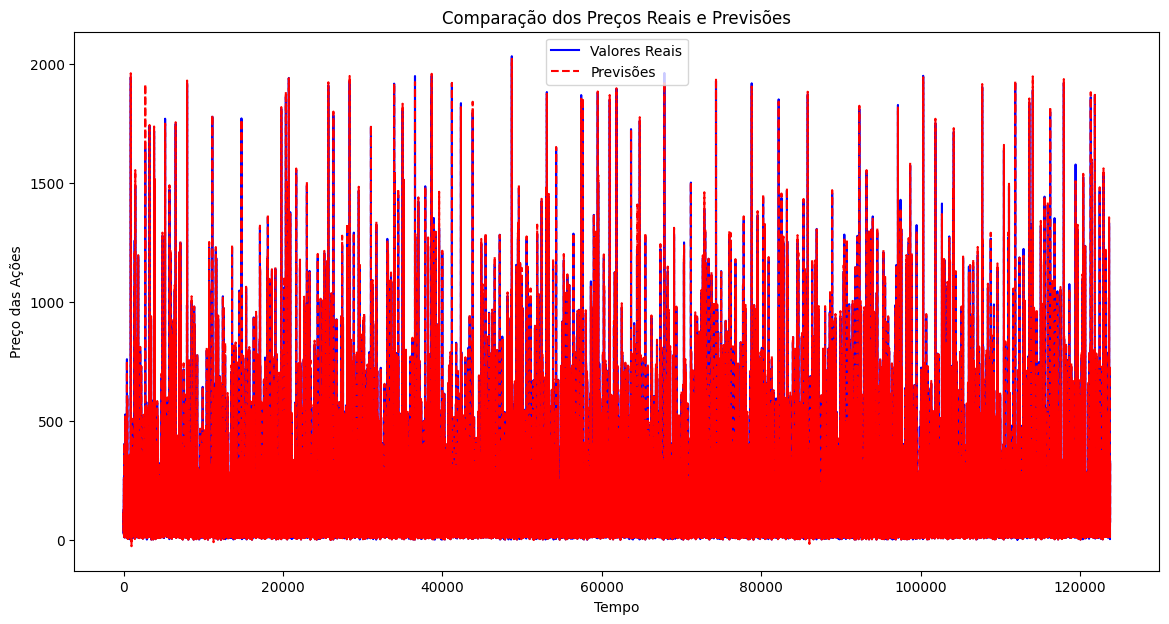

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Carregar os dados
df

# Supondo que 'close' seja a coluna com os preços de fechamento das ações
prices = df['close'].values

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

# Criar dados sequenciais para o LSTM
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100
X, y = create_dataset(prices_scaled, time_step)

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape input para ser [samples, time steps, features] que é requerido para LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Construir o modelo LSTM
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(X_train, y_train, batch_size=64, epochs=10)

# Fazer previsões
predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)  # Inverter a normalização

# Calcular métricas de desempenho
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")

# Plotar os valores reais e previstos
plt.figure(figsize=(14, 7))
plt.plot(y_test_rescaled, label='Valores Reais', color='blue')
plt.plot(predictions_rescaled, label='Previsões', color='red', linestyle='--')
plt.title('Comparação dos Preços Reais e Previsões')
plt.xlabel('Tempo')
plt.ylabel('Preço das Ações')
plt.legend()
plt.show()

Iremos criar o modelo preditivo utilizando o algoritmo de ARIMA (Auto Regressive Integrated Moving Averages).

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this

Mean Absolute Error (MAE): 35.19383341551226
Mean Squared Error (MSE): 2752.01208588945
R^2 Score: -0.3195305155283401


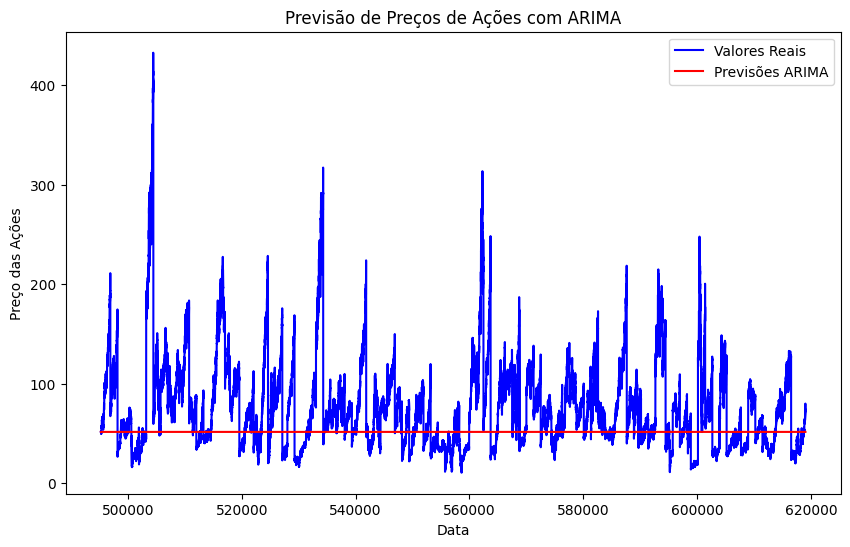

In [6]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Carregar os dados
df
# Supondo que estamos interessados na coluna 'close' para o preço de fechamento
close_prices = df['close']

# Dividir os dados em conjuntos de treinamento e teste
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[0:train_size], close_prices[train_size:len(close_prices)]

# Ajustar o modelo ARIMA
model = ARIMA(train, order=(5,1,0))  # Os parâmetros (p, d, q) podem precisar ser ajustados
model_fit = model.fit()

# Previsões
predictions = model_fit.forecast(len(test))
predictions = np.array(predictions)

# Avaliar o modelo
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R^2 Score:", r2)

# Plotar os resultados
plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='Valores Reais', color='blue')
plt.plot(test.index, predictions, label='Previsões ARIMA', color='red')
plt.title('Previsão de Preços de Ações com ARIMA')
plt.xlabel('Data')
plt.ylabel('Preço das Ações')
plt.legend()
plt.show()

Resultados

A regressão linear tem um desempenho excelente, com erros absolutos e quadrados muito baixos e um coeficiente de determinação quase perfeito. Isso indica que o modelo tem uma precisão notável para a maioria das previsões.

O modelo LSTM, que é um tipo de rede neural recorrente especializada em capturar relações temporais em séries temporais, tem erros absolutos e quadrados significativamente maiores do que a regressão linear, indicando que ele não foi tão preciso. No entanto, o R² ainda é muito alto, o que significa que, apesar dos erros maiores, o modelo ainda captura bem a variação dos dados.

O modelo ARIMA, um modelo clássico para previsão de séries temporais, apresenta erros absolutos e quadrados extremamente altos, e um R² negativo. Isso indica que o modelo ARIMA não conseguiu capturar a variação dos dados e na verdade fez previsões piores do que um modelo ingênuo que sempre prevê a média dos dados.

Conclusão

A regressão linear é claramente o modelo mais preciso entre os três, com o menor MAE e MSE e o maior R², indicando que ele pode prever a variação dos dados quase perfeitamente.

O modelo LSTM, apesar de não tão preciso quanto a regressão linear, ainda é um modelo robusto com um bom R².

O ARIMA, por outro lado, parece inadequado para os dados em questão, já que suas previsões são muito piores do que um modelo simples de previsão da média. Isso pode acontecer se a série temporal tiver características, como não-estacionariedade ou padrões complexos, que não são bem modelados pelo ARIMA